In [1]:
import nir
# import nirtorch
import torch
# import numpy as np
import lava.lib.dl.slayer as slayer
import snntorch as snn
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 2]
plt.rcParams['figure.dpi'] = 200

In [2]:
dt = 1e-4
scale = 1 << 6
# general params
lif_size = 2
vthr = 1.0
# lava-dl
i_decay = 0.45
v_decay = 0.1
# snnTorch
alpha = 1 - i_decay
beta = 1 - v_decay

In [3]:
w_in = torch.eye(lif_size)
w_rec = torch.rand((lif_size, lif_size)) * 0.3
# b_rec = torch.rand((lif_size,))
w_in.shape, w_rec.shape

(torch.Size([2, 2]), torch.Size([2, 2]))

In [4]:
def snntorch_net():
    rsynaptic = snn.RSynaptic(
        alpha=alpha,
        beta=beta,
        threshold=vthr,
        reset_mechanism='zero',
        init_hidden=False,
        all_to_all=True,
        linear_features=lif_size,
        # V=V,
        reset_delay=False,
    )
    rsynaptic.recurrent.weight.data = w_rec.clone()
    rsynaptic.recurrent.bias = None
    return rsynaptic
    # rsynaptic.recurrent.bias = torch.nn.Parameter(b_rec.clone())
    # rsynaptic.recurrent.bias

In [5]:
def lava_net():
    rnn_lava = slayer.block.cuba.Recurrent(
        in_neurons=lif_size,
        out_neurons=lif_size,
        weight_scale=1,
        weight_norm=False,
        pre_hook_fx=None,
        delay_shift=False,
        neuron_params=dict(
            threshold=vthr,
            current_decay=i_decay,
            voltage_decay=v_decay,
            shared_param=True,
            scale=scale,
        )
    )
    w_in_shape = rnn_lava.input_synapse.weight.data.shape
    rnn_lava.input_synapse.weight.data = w_in.reshape(w_in_shape)
    w_rec_shape = rnn_lava.recurrent_synapse.weight.data.shape
    rnn_lava.recurrent_synapse.weight.data = w_rec.reshape(w_rec_shape)
    return rnn_lava
    # rnn_lava.input_synapse.bias, rnn_lava.recurrent_synapse.bias

In [6]:
rnn_snntorch = snntorch_net()
rnn_lava = lava_net()

In [7]:
seq_len = 200
ut = np.random.random((lif_size, seq_len))
ut = (ut > 0.95).astype(np.float32)
ut = torch.from_numpy(ut).reshape(1, lif_size, seq_len)

In [8]:
ut_scale = 0.6

In [9]:
rnn_lava = lava_net()

In [10]:
out_lava = rnn_lava(ut * ut_scale).detach().numpy()

In [11]:
out_lava

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

In [11]:
spk, syn, mem = rnn_snntorch.init_rsynaptic()
out_snntorch = []
for t in range(seq_len):
    spk, syn, mem = rnn_snntorch(ut[:, :, t] * ut_scale, spk, syn, mem)
    out_snntorch.append(spk.detach().numpy())
out_snntorch = np.stack(out_snntorch, axis=-1)

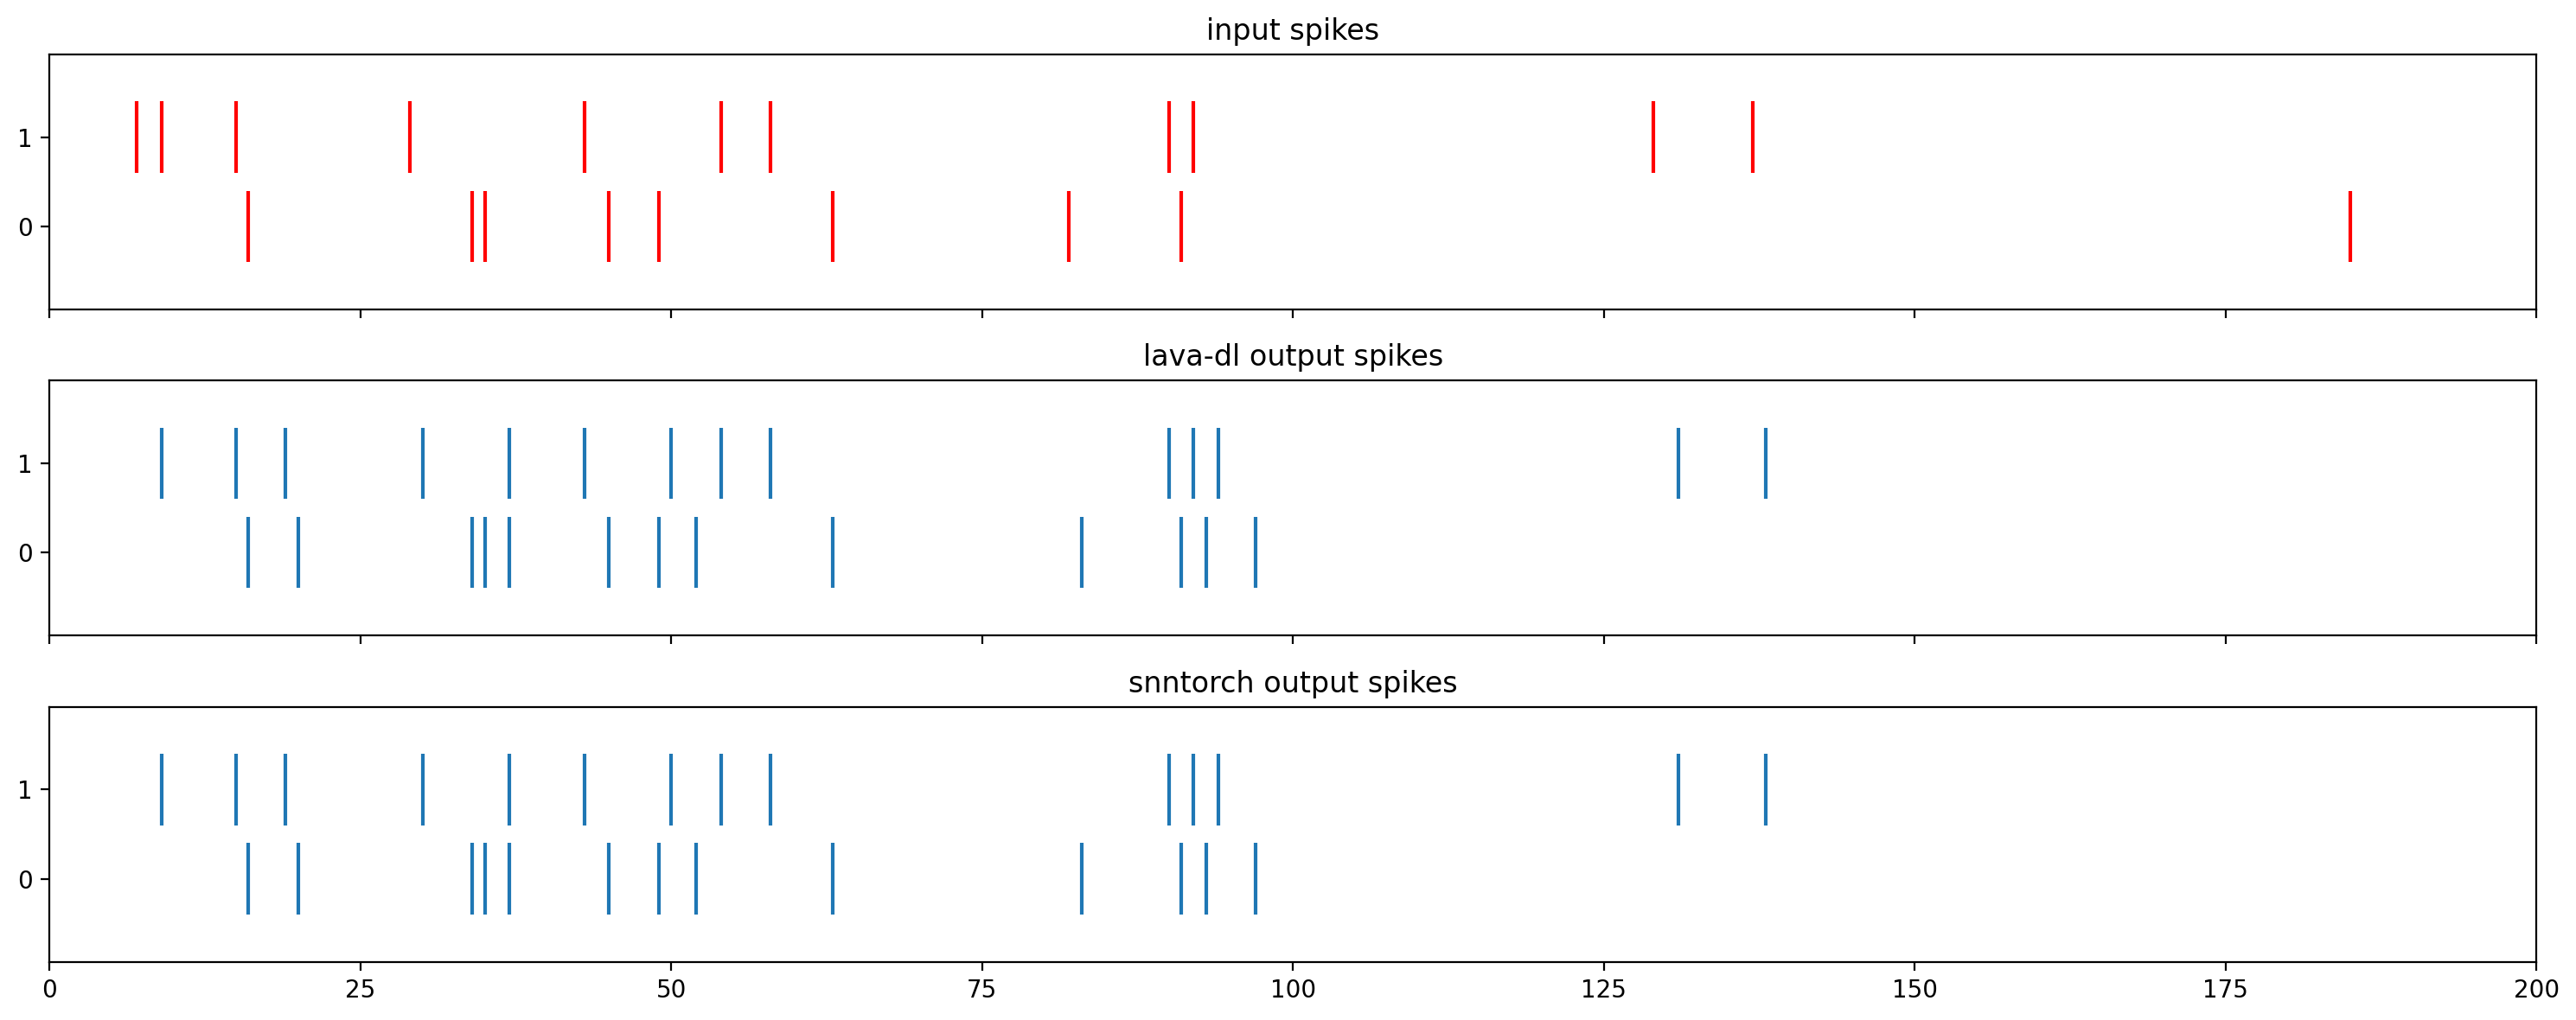

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(15, 6), dpi=200, sharex=True)
axs[0].set_title('input spikes')
axs[0].set_xlim(0, seq_len)
for idx, ut_idx in enumerate(ut[0]):
    axs[0].eventplot(np.where(ut_idx == 1)[0], lineoffsets=idx, linelengths=0.8, color='red')
axs[1].set_title('lava-dl output spikes')
axs[1].set_xlim(0, seq_len)
for idx, yt_idx in enumerate(out_lava[0]):
    axs[1].eventplot(np.where(yt_idx == 1)[0], lineoffsets=idx, linelengths=0.8)
axs[2].set_title('snntorch output spikes')
axs[2].set_xlim(0, seq_len)
for idx, yt_idx in enumerate(out_snntorch[0]):
    axs[2].eventplot(np.where(yt_idx == 1)[0], lineoffsets=idx, linelengths=0.8)
plt.tight_layout()